In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join, exists
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import json
from PIL import Image

# Toydata

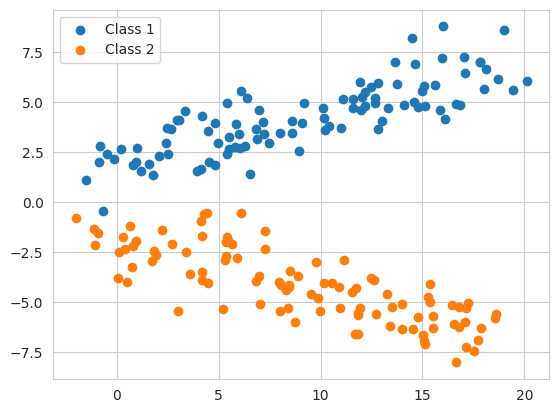

In [2]:
# Generate data for two classes from 4 clusters
n_samples = 10 # pro cluster - divide by 2 for n_samples per class
n_clusters = 10 # Number of Clusters along the decision border
dist_cluster = 2 # distance of clusters
pos_cls = []
neg_cls = []

for i in range(n_clusters):
    mean_pos_cls = [i * dist_cluster, 2  + 0.5 * i]
    mean_neg_cls = [i * dist_cluster, -2 - 0.5 * i]
    cov = [[1, 0], [0, 1]]

    pos_cluster = np.random.multivariate_normal(mean_pos_cls, cov, n_samples)
    neg_cluster = np.random.multivariate_normal(mean_neg_cls, cov, n_samples)
    pos_cls.append(pos_cluster)
    neg_cls.append(neg_cluster)

data_pos = np.concatenate(pos_cls, axis=0)
data_neg = np.concatenate(neg_cls, axis=0)

# Plot the clusters

fig, ax = plt.subplots()
ax.scatter(data_pos[:, 0], data_pos[:, 1], label='Class 1')
ax.scatter(data_neg[:, 0], data_neg[:, 1], label='Class 2')

ax.legend()
plt.show()

# Mean / STD convergence

In [3]:
def shuffle(v):
    ids = np.arange(len(v))
    np.random.shuffle(ids)
    return v[ids]

def auc(values):
    v = np.sum(values, axis=1) / values.shape[1]
    return np.squeeze(v)

def mean_std_curves(inpt):
    mean_develop = [np.median(inpt[:i]) for i in range(1, len(inpt) + 1)]
    # median_develop = [np.median(inpt[:i]) for i in range(1, len(inpt) + 1)]
    std_develop = [np.std(inpt[:i]) for i in range(1, len(inpt) + 1)]
    return mean_develop, std_develop

def plot(ax, points, trajectories, twin, color, title):
    # ax.set_ylabel("mean")
    ax.set_xlabel("eval run")
    ax.scatter(range(len(points)), points, c="r", s=9, alpha=0.3)
    ax.grid()
    if twin:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    for line in trajectories:
        ax2.plot(line, c=color, alpha=0.3)
    ax2.grid()
    ax.set_title(title)

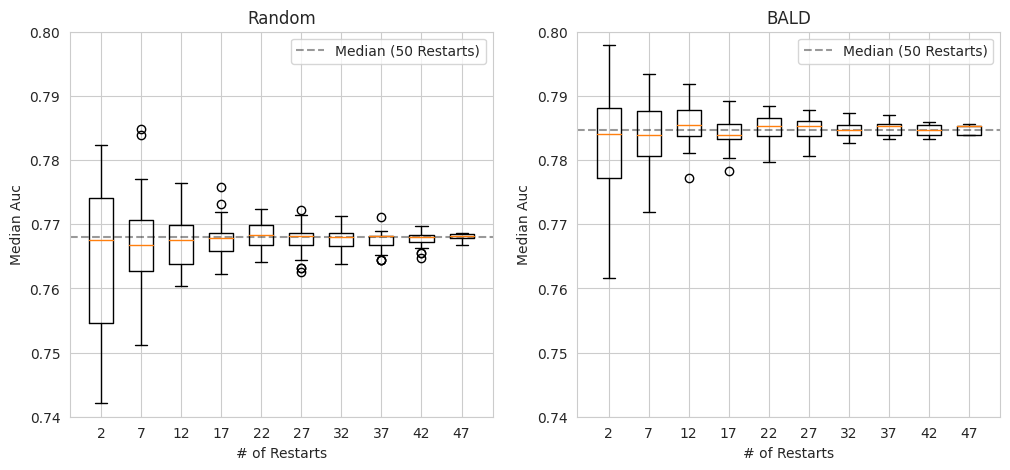

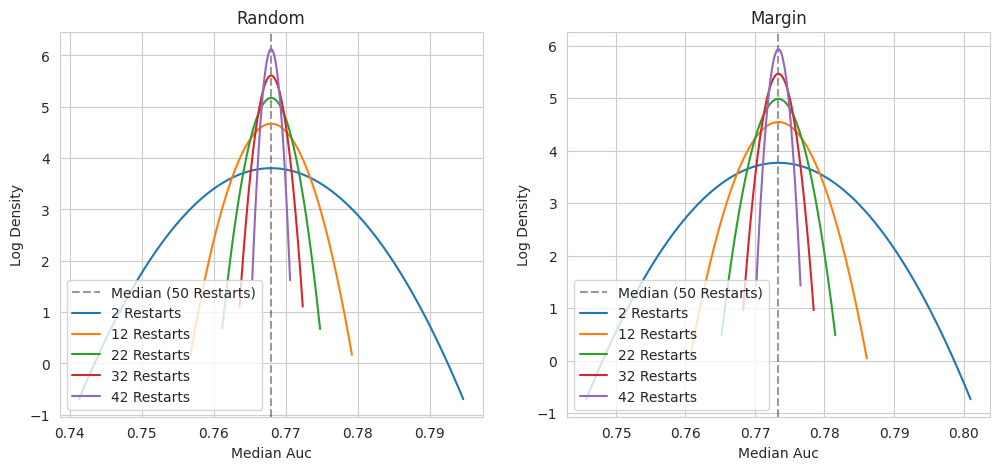

In [22]:
import scipy.stats as stats

def do_box(ax, file, title):
    accuracies = pd.read_csv(file, header=0, index_col=0)
    values = auc(accuracies.values.T)
    true_median = np.median(values)
    medians = []
    sizes = []
    for size in range(2, len(values), 5):
        current = []
        for _ in range(50):
            v = shuffle(values)[:size]
            current.append(np.median(v))
        medians.append(current)
        sizes.append(size)
    ax.axhline(true_median, label="Median (50 Restarts)", linestyle="--", c="black", alpha=0.4)
    # ax.axhline(0.814, label="Oracle", linestyle="--", c="red", alpha=0.4)
    ax.boxplot(medians, widths=3, positions=sizes)
    ax.set_xlabel("# of Restarts")
    ax.set_ylabel("Median Auc")
    ax.set_title(title)
    ax.set_ylim(0.74, 0.8)
    ax.legend()

def do_normal(ax, file, title):
    accuracies = pd.read_csv(file, header=0, index_col=0)
    values = auc(accuracies.values.T)
    true_median = np.median(values)
    ax.axvline(true_median, label="Median (50 Restarts)", linestyle="--", c="black", alpha=0.4)
    for size in range(2, len(values), 10):
        current = []
        for _ in range(50):
            v = shuffle(values)[:size]
            current.append(np.median(v))
        std = np.std(current)
        x = np.linspace(true_median - 3*std, true_median + 3*std, 100)
        ax.plot(x, stats.norm.logpdf(x, true_median, std), label=f"{size} Restarts")
    ax.set_xlabel("Median Auc")
    ax.set_ylabel("Log Density")
    ax.set_title(title)
    # ax.set_yscale("log")
    ax.legend()

np.random.seed(2023)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
do_box(ax1, "runs/Splice/RandomAgent/accuracies.csv", "Random")
do_box(ax2, "runs/Splice/BALD/accuracies.csv", "BALD")
plt.savefig("doc/img/ablation_restarts.jpg")
plt.show()
plt.close(fig)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
do_normal(ax1, "runs/Splice/RandomAgent/accuracies.csv", "Random")
do_normal(ax2, "runs/Splice/MarginScore/accuracies.csv", "Margin")
plt.savefig("doc/img/ablation_restarts_2.jpg")
plt.show()
plt.close(fig)


# Visualizing trajectories

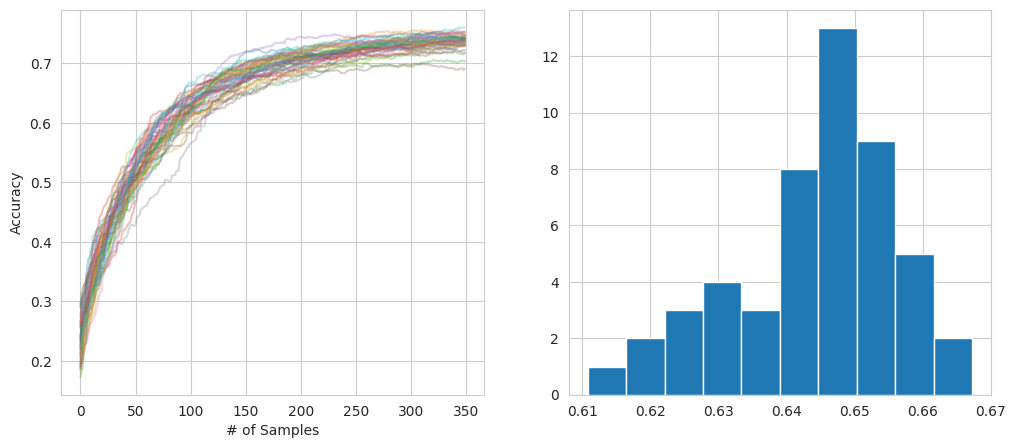

In [5]:
def view_trajectories(ax, file):
    accuracies = pd.read_csv(file, header=0, index_col=0)
    values = accuracies.values.T
    for line in values:
        ax.plot(line, alpha=0.3)
    ax.set_xlabel("# of Samples")
    ax.set_ylabel("Accuracy")

def view_hist(ax, file):
    accuracies = pd.read_csv(file, header=0, index_col=0)
    values = auc(accuracies.values.T)
    ax.hist(values)

file = "runs/Cifar10Encoded/MarginScore/accuracies.csv"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
view_trajectories(ax1, file)
view_hist(ax2, file)
plt.show()
plt.close(fig)

# Tukey Test for Statistical Significance

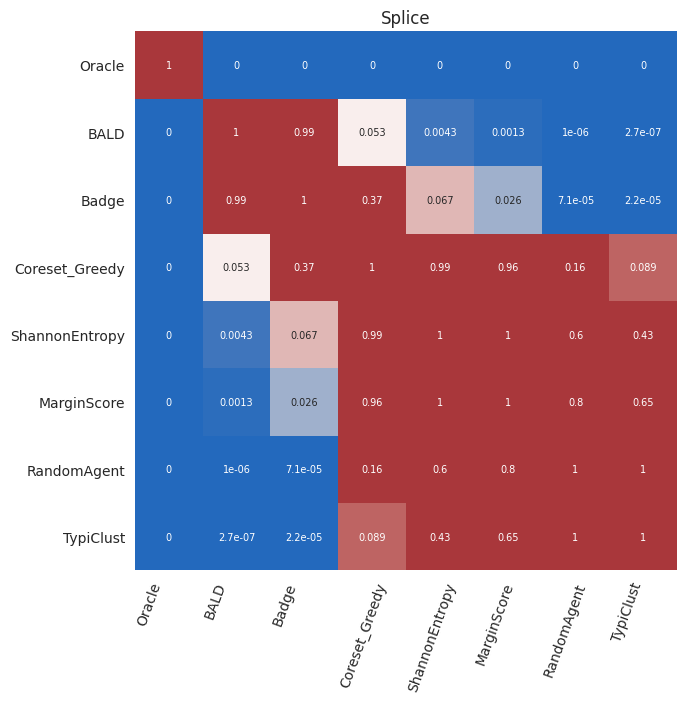

In [6]:
from scipy.stats import tukey_hsd
import os
from os.path import exists, join
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def _pad_nans_with_last_value(df:pd.DataFrame):
    max_len = len(df)
    for col in df:
        diff = max_len - sum(pd.notna(df[col]))
        if diff > 0:
            last_val = df[col][sum(pd.notna(df[col])) - 1]
            df[col] = pd.concat([df[col].iloc[:-diff], pd.Series([last_val]*diff)], ignore_index=True)
    return df

def do_tukey(agents, dataset):
    dataset_folder = os.path.join("runs", dataset)
    all_means = []
    all_aucs = []

    for agent in agents:
        agent_folder = join(dataset_folder, agent)
        if exists(agent_folder):
            acc_file = join(agent_folder, "accuracies.csv")
            if exists(acc_file):
                accuracies = pd.read_csv(acc_file, header=0, index_col=0)
                accuracies = _pad_nans_with_last_value(accuracies)
                values = accuracies.values
                auc = np.sum(values, axis=0) / values.shape[0]
                means = np.mean(auc).item()
                all_means.append(means)
                all_aucs.append(auc)
        else:
            print(f"{agent} is missing for {dataset}")
    z = zip(all_means, all_aucs, agents)
    z = sorted(z)
    all_means, all_aucs, agents = zip(*z)
    all_means = all_means[::-1]
    all_aucs = all_aucs[::-1]
    agents = agents[::-1]
    res = tukey_hsd(*all_aucs)

    p = (res.pvalue > 0.05).astype(int)
    fig, ax = plt.subplots(figsize=(7,7))
    cmap = sns.color_palette("vlag", as_cmap=True)
    sns.heatmap(res.pvalue, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=0.1, center=0.05,
                annot=True, annot_kws={"size": 7})
    ax.set_yticks(np.arange(len(agents)), agents, rotation=0)
    for label in ax.yaxis.get_majorticklabels():
        offset = matplotlib.transforms.ScaledTranslation(0, -0.35, fig.dpi_scale_trans)
        label.set_transform(label.get_transform() + offset)
    ax.set_xticks(np.arange(len(agents)), agents, rotation=70, ha="left")


agents = ["Oracle", "Coreset_Greedy", "TypiClust", "MarginScore", "ShannonEntropy", "RandomAgent", "Badge", "BALD", ]
vector_data = ["Splice", "DNA", "USPS"]
enc_vector_data = ["SpliceEncoded", "DNAEncoded", "USPSEncoded"]
img_data = ["Cifar10Encoded", "FashionMnistEncoded"]
text_data = ["TopV2", "News"]

res = do_tukey(agents, "Splice")
plt.title("Splice")
print()

In [7]:
fig.axes[0]


<AxesSubplot: xlabel='# of Samples', ylabel='Accuracy'>